# Predicting indoor temperature (inside a solar home)

<big><font color="grey"><b>Aksana Lefter</b></font></big>

A Solar panels (also known as "PV panels") is a device that converts light from the sun, which is composed of particles of energy called "photons", into electricity that can be used to power electrical loads.

Solar panels can be used for a wide variety of applications including remote power systems for cabins, telecommunications equipment, remote sensing, and of course for the production of electricity by residential and commercial solar electric systems.[1]

The dataset covers around 40 days of monitoring. The objective is to forecast the indoor temperature of a specific room (the Bedroom) to decide when to activate the HVAC (Heating, Ventilation, and Air Conditioning) system.

## Data analysis

Loading data and libraries.

In [1]:
# Library installation
!pip install pandas -q
!pip install numpy -q
!pip install matplotlib -q
!pip install seaborn -q
!pip install gdown -q
!pip install plotly -q
!pip install scikit-learn -q
!pip install xgboost -q

In [2]:
# Library import
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import math

import xgboost as xgb
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import TimeSeriesSplit


from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

Let's upload three files: the training sample, the test sample, and an example of the expected result.

In [3]:
# Load data first 7 lines - training sample
try:
    train = pd.read_csv("trainsolar.csv")
    print("uploaded locally")
except:
    file_id = '1b2pY_ch0EcdPdroV0KI3brIJRGNt3vcE'
    url = f'https://drive.google.com/uc?id={file_id}'
    output = 'trainsolarhouse.csv'
    gdown.download(url, output, quiet=False)
    train = pd.read_csv(output)
    print("data download")
train.head(7)

uploaded locally


,Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room
0,0,13/03/2012,11:45,216.560,221.920,39.9125,42.4150,81.6650,113.520,0.0,623.360,1.42625,9690.24,12604.20,95436.8,758.880,48.3750,2.0,17.8275
1,1,13/03/2012,12:00,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,623.211,1.59200,11022.00,10787.20,95436.8,762.069,47.8080,2.0,18.1207
2,2,13/03/2012,12:15,219.403,218.933,39.7720,42.2267,81.4240,113.600,0.0,622.656,1.89133,13960.50,9669.63,95398.6,766.251,47.4320,2.0,18.4367
3,3,13/03/2012,12:30,218.613,217.045,39.7760,42.0987,81.5013,113.344,0.0,622.571,1.82800,18511.20,9648.13,95360.3,766.037,47.0240,2.0,18.7513
4,4,13/03/2012,12:45,217.714,216.080,39.7757,42.0686,81.4657,113.034,0.0,622.400,2.36071,26349.00,9208.32,95354.9,762.743,45.4743,2.0,19.0414
5,5,13/03/2012,13:00,218.389,216.011,39.8107,42.0347,81.2427,113.600,0.0,622.400,2.06333,36511.70,8694.78,95354.9,752.683,45.5467,2.0,19.2773
6,6,13/03/2012,13:15,218.155,215.829,39.8613,41.9947,81.3600,112.981,0.0,622.400,2.23067,49288.50,8501.25,95354.9,740.949,44.9680,2.0,19.5367


In [4]:
# Load data first 7 lines - test sample
try:
    test = pd.read_csv("testsolar.csv")
    print("uploaded locally")
except:
    file_id = '1ktU_m3b3yDW2Z3KOwKG-HhSrs4jpZJ_K'
    url = f'https://drive.google.com/uc?id={file_id}'
    output = 'testsolarhouse.csv'
    gdown.download(url, output, quiet=False)
    test = pd.read_csv(output)
    print("data download")
test.head(7)

uploaded locally


,Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week
0,2764,18/04/2012,00:00,207.840,206.560,31.5800,30.1600,11.7200,14.1600,0.0,0.65,0.000000,0.0,0.0,0.0,-3.12000,39.0800,3.0
1,2765,18/04/2012,00:15,207.499,206.101,31.6240,30.0613,11.5240,14.7600,0.0,0.65,0.000000,0.0,0.0,0.0,-2.80800,38.9680,3.0
2,2766,18/04/2012,00:30,207.360,206.805,31.6507,30.1773,11.6220,14.9547,0.0,0.65,0.088000,0.0,0.0,0.0,-2.96400,38.9467,3.0
3,2767,18/04/2012,00:45,207.445,206.325,31.6987,30.2560,11.7847,15.0520,0.0,0.65,0.127333,0.0,0.0,0.0,-3.02933,39.0760,3.0
4,2768,18/04/2012,01:00,207.840,205.952,31.7707,30.3840,11.5887,15.2147,0.0,0.65,0.000000,0.0,0.0,0.0,-2.88600,40.0413,3.0
5,2769,18/04/2012,01:15,207.648,206.357,31.9120,30.4173,11.6053,15.2147,0.0,0.65,0.000000,0.0,0.0,0.0,-2.88600,41.6613,3.0
6,2770,18/04/2012,01:30,207.701,207.893,31.9800,30.4333,11.6220,15.1333,0.0,0.65,0.036000,0.0,0.0,0.0,-2.96400,41.4747,3.0


In [5]:
# Load data first 7 lines - sample submission
try:
    sample_submission = pd.read_csv("sample_submission.csv")
    print("uploaded locally")
except:
    file_id = '18G99eSdqscxy2z4tXyiVmcfLgv8XQ8Ob'
    url = f'https://drive.google.com/uc?id={file_id}'
    output = 'solarhouse.csv'
    gdown.download(url, output, quiet=False)
    sample_submission = pd.read_csv(output)
    print("data download")
sample_submission.head(7)

uploaded locally


,Id,Indoor_temperature_room
0,2764,0.0
1,2765,0.0
2,2766,0.0
3,2767,0.0
4,2768,0.0
5,2769,0.0
6,2770,0.0


Let's check the training and test samples for missing data.

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Id                                2764 non-null   int64  
 1   Date                              2764 non-null   object 
 2   Time                              2764 non-null   object 
 3   CO2_(dinning-room)                2764 non-null   float64
 4   CO2_room                          2764 non-null   float64
 5   Relative_humidity_(dinning-room)  2764 non-null   float64
 6   Relative_humidity_room            2764 non-null   float64
 7   Lighting_(dinning-room)           2764 non-null   float64
 8   Lighting_room                     2764 non-null   float64
 9   Meteo_Rain                        2764 non-null   float64
 10  Meteo_Sun_dusk                    2764 non-null   float64
 11  Meteo_Wind                        2764 non-null   float64
 12  Meteo_

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1373 entries, 0 to 1372
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Id                                1373 non-null   int64  
 1   Date                              1373 non-null   object 
 2   Time                              1373 non-null   object 
 3   CO2_(dinning-room)                1373 non-null   float64
 4   CO2_room                          1373 non-null   float64
 5   Relative_humidity_(dinning-room)  1373 non-null   float64
 6   Relative_humidity_room            1373 non-null   float64
 7   Lighting_(dinning-room)           1373 non-null   float64
 8   Lighting_room                     1373 non-null   float64
 9   Meteo_Rain                        1373 non-null   float64
 10  Meteo_Sun_dusk                    1373 non-null   float64
 11  Meteo_Wind                        1373 non-null   float64
 12  Meteo_

Data without omissions. Let's replace the date in the samples with datetime format.

In [8]:
train['Date_time'] = pd.to_datetime(train['Date'] + ' ' + train['Time'], format='%d/%m/%Y %H:%M')
test['Date_time'] = pd.to_datetime(test['Date'] + ' ' + test['Time'], format='%d/%m/%Y %H:%M')

Let's add the columns: month, day, hour, minutes, weekday, and quarter.

In [9]:
train['month'] = train['Date_time'].dt.month
train['day'] = train['Date_time'].dt.day
train['quarter'] = train['Date_time'].dt.quarter
train['weekday'] = train['Date_time'].dt.weekday
train['hour'] = train['Date_time'].dt.hour
train['minute'] = train['Date_time'].dt.minute

test['month'] = test['Date_time'].dt.month
test['day'] = test['Date_time'].dt.day
test['quarter'] = test['Date_time'].dt.quarter
test['weekday'] = test['Date_time'].dt.weekday
test['hour'] = test['Date_time'].dt.hour
test['minute'] = test['Date_time'].dt.minute

Let's sort the data by time to obtain a correct time series.

In [10]:
train = train.sort_values(by='Date_time')
test = test.sort_values(by='Date_time')

Let's set the Date_time column as the index.

In [11]:
train.set_index('Date_time', inplace=True)
test.set_index('Date_time', inplace=True)

Let's explore the distribution of temperature by day of the week.

Text(0.5, 1.0, 'Weekday temperature')

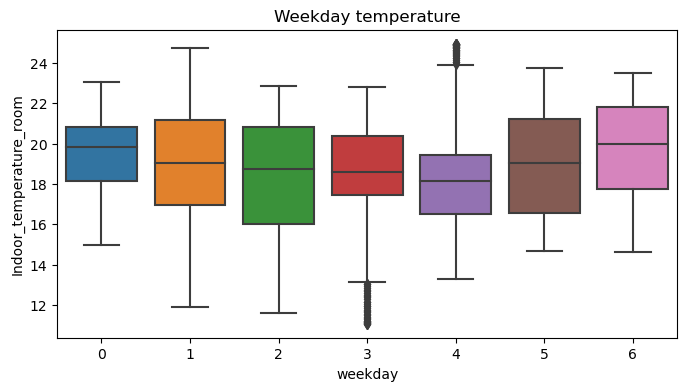

In [12]:
fig,ax = plt.subplots(figsize=(8,4))
sns.boxplot(data=train, x='weekday',y='Indoor_temperature_room')
ax.set_title('Weekday temperature')

From the graph, we observe that the median temperature remains relatively consistent from Tuesday through Saturday, while on Monday and Sunday, it is higher. Now, let's examine the temperature variations throughout the day by hour.

Text(0.5, 1.0, 'Temperature by hours')

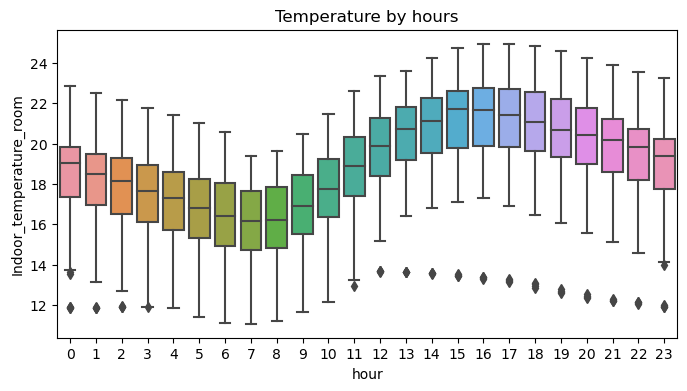

In [13]:
fig,ax = plt.subplots(figsize=(8,4))
sns.boxplot(data=train, x='hour',y='Indoor_temperature_room')
ax.set_title('Temperature by hours')

The graph reveals a pattern of temperature rising during the day, followed by a decline in the evening until morning, then rising again. Additionally, there are outliers, indicating that some days experienced temperatures below the average.

Since our data includes various parameters, let's examine the correlations with room temperature. For instance, we may observe that as the temperature rises, humidity tends to decrease."

In [14]:
train.corrwith(train['Indoor_temperature_room'])

Id                                  0.246559
CO2_(dinning-room)                  0.061361
CO2_room                            0.056195
Relative_humidity_(dinning-room)   -0.275193
Relative_humidity_room             -0.417901
Lighting_(dinning-room)             0.069264
Lighting_room                       0.002253
Meteo_Rain                         -0.262621
Meteo_Sun_dusk                      0.068897
Meteo_Wind                          0.220667
Meteo_Sun_light_in_west_facade      0.335288
Meteo_Sun_light_in_east_facade     -0.269034
Meteo_Sun_light_in_south_facade     0.000072
Meteo_Sun_irradiance                0.123390
Outdoor_relative_humidity_Sensor   -0.549681
Day_of_the_week                     0.016517
Indoor_temperature_room             1.000000
month                               0.221157
day                                -0.147394
quarter                             0.221157
weekday                             0.014423
hour                                0.417876
minute    

It's evident that room temperature correlates with the outdoor relative humidity sensor.

## Modeling

Let's move on to modeling. First, we'll combine the training and test samples.

In [15]:
df = pd.concat([train, test])

Let's remove the unnecessary columns: ID, Date, Time, and Day_of_the_week.

In [16]:
df = df.drop(['Date','Time','Id', 'Day_of_the_week'], axis=1)

Given the correlation between humidity and temperature, let's incorporate lags for 15, 30, 45, and 60 minutes.

In [17]:
df['Lag_60_Min'] = df['Outdoor_relative_humidity_Sensor'].shift(1, freq='H')
df['Lag_15_Min'] = df['Outdoor_relative_humidity_Sensor'].shift(1, freq='15T')
df['Lag_30_Min'] = df['Outdoor_relative_humidity_Sensor'].shift(2, freq='30T')
df['Lag_45_Min'] = df['Outdoor_relative_humidity_Sensor'].shift(3, freq='45T')

Lags have been added. The first 9 lines contain missing data, so we'll remove them

In [18]:
df = df.drop(df.index[:9])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4128 entries, 2012-03-13 14:00:00 to 2012-05-02 07:30:00
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CO2_(dinning-room)                4128 non-null   float64
 1   CO2_room                          4128 non-null   float64
 2   Relative_humidity_(dinning-room)  4128 non-null   float64
 3   Relative_humidity_room            4128 non-null   float64
 4   Lighting_(dinning-room)           4128 non-null   float64
 5   Lighting_room                     4128 non-null   float64
 6   Meteo_Rain                        4128 non-null   float64
 7   Meteo_Sun_dusk                    4128 non-null   float64
 8   Meteo_Wind                        4128 non-null   float64
 9   Meteo_Sun_light_in_west_facade    4128 non-null   float64
 10  Meteo_Sun_light_in_east_facade    4128 non-null   float64
 11  Meteo_Sun_light_in_south_facade  

We will replace the remaining missing values with the median.

In [20]:
columns_to_fill = ['Lag_60_Min','Lag_15_Min','Lag_30_Min','Lag_45_Min']
df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].median())

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4128 entries, 2012-03-13 14:00:00 to 2012-05-02 07:30:00
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CO2_(dinning-room)                4128 non-null   float64
 1   CO2_room                          4128 non-null   float64
 2   Relative_humidity_(dinning-room)  4128 non-null   float64
 3   Relative_humidity_room            4128 non-null   float64
 4   Lighting_(dinning-room)           4128 non-null   float64
 5   Lighting_room                     4128 non-null   float64
 6   Meteo_Rain                        4128 non-null   float64
 7   Meteo_Sun_dusk                    4128 non-null   float64
 8   Meteo_Wind                        4128 non-null   float64
 9   Meteo_Sun_light_in_west_facade    4128 non-null   float64
 10  Meteo_Sun_light_in_east_facade    4128 non-null   float64
 11  Meteo_Sun_light_in_south_facade  

Now, let's split the data into training and test samples.

In [22]:
train_sample = df.loc[df.index < '2012-04-04']
test_sample = df.loc[(df.index >= '2012-04-04') & (df.index <= '2012-04-11')]
test_actual = df.loc[df.index >= '2012-04-18']

Let's create the lists for Features and Target variables.

In [23]:
FEATURES = ['CO2_(dinning-room)', 'CO2_room', 'Relative_humidity_(dinning-room)',
       'Relative_humidity_room', 'Lighting_(dinning-room)', 'Lighting_room',
       'Meteo_Rain', 'Meteo_Sun_dusk', 'Meteo_Wind',
       'Meteo_Sun_light_in_west_facade', 'Meteo_Sun_light_in_east_facade',
       'Meteo_Sun_light_in_south_facade', 'Meteo_Sun_irradiance',
       'Outdoor_relative_humidity_Sensor', 'month',
       'day', 'quarter', 'weekday', 'hour', 'minute', 'Lag_60_Min',
       'Lag_15_Min', 'Lag_30_Min', 'Lag_45_Min']
TARGET = ['Indoor_temperature_room']

Let's finalize the split into training and test samples.

In [24]:
X_train = train_sample[FEATURES]
y_train = train_sample[TARGET]
X_test = test_sample[FEATURES]
y_test = test_sample[TARGET]
X_test_actual = test_actual[FEATURES]

Our data includes various numerical parameters, and it would be beneficial to apply standardization. Nevertheless, the models we plan to use have built-in mechanisms to standardize the data during training.

Let's employ the Dummy Regressor model and examine the results. We will assess the outcome using the Mean Squared Error metric.

Mean Squared Error represents the average of the squared difference between the original and predicted values in the data set. It measures the variance of the residuals.[2]

In [25]:
dr = DummyRegressor()
tscv = TimeSeriesSplit(n_splits=5)
scores_dr = cross_val_score(dr, X_train, y_train, cv=tscv,scoring='neg_mean_squared_error')
print('Cross-Validation Mean squared error Scores', scores_dr)
print('Mean MSE Score', scores_dr.mean())

Cross-Validation Mean squared error Scores [ -8.8223574  -20.75193939  -5.17437001 -11.04177202  -8.95968873]
Mean MSE Score -10.950025508228514


The next model we'll use is XGBoost. Let's choose the hyperparameters and see the results.

In [26]:
# hyperparameters using RandomizedSearchCV

xgb = XGBRegressor()
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 7, 9],
    'subsample': [0.5, 0.7, 0.6, 0.4],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'objective': ['reg:squarederror']    
}

random_search_xgb = RandomizedSearchCV(xgb, param_distributions=xgb_params, n_iter=10, cv=tscv, \
                                       n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
random_search_xgb.fit(X_train, y_train)

print("Best parameters: ", random_search_xgb.best_params_)
print("Mean squared error: ", random_search_xgb.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'subsample': 0.4, 'objective': 'reg:squarederror', 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Mean squared error:  -3.4953953223940397


In [27]:
xgb = XGBRegressor(**random_search_xgb.best_params_)
scores_xgbh= cross_val_score(xgb, X_train, y_train, cv=tscv,scoring='neg_mean_squared_error')
print('Cross-Validation Mean squared error Scores', scores_xgbh)
print('Mean MSE Score', scores_xgbh.mean())

Cross-Validation Mean squared error Scores [-3.78710806 -4.71885299 -3.98396523 -1.48117664 -3.50587369]
Mean MSE Score -3.4953953223940397


Let's take another look at CatBoost.

In [28]:
# hyperparameters using RandomizedSearchCV
cb = CatBoostRegressor()
param_dist_cb = {
    'iterations': [100, 200, 300, 400, 500],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
}

random_search_cb = RandomizedSearchCV(estimator=cb, param_distributions=param_dist_cb, n_iter=10, \
                                      cv=tscv, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
random_search_cb.fit(X_train, y_train)

print("Best parameters: ", random_search_cb.best_params_)
print("Mean squared error: ", random_search_cb.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, objective=reg:squarederror, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=5, objective=reg:squarederror, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, objective=reg:squarederror, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, objective=reg:squarederror, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_weight=5, objective=reg:squarederror, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=7, min_child_weight=9, objective=reg:squarederror, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, 

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=5, objective=reg:squarederror, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, objective=reg:squarederror, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=5, objective=reg:squarederror, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_weight=5, objective=reg:squarederror, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_weight=5, objective=reg:squarederror, subsample=0.5; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=3, objective=reg:squarederror, subsample=0.4; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=3, objective=reg:squarederror, subsample=0.4

94:	learn: 0.0678951	total: 396ms	remaining: 854ms
95:	learn: 0.0672031	total: 398ms	remaining: 846ms
96:	learn: 0.0665512	total: 400ms	remaining: 837ms
97:	learn: 0.0658207	total: 402ms	remaining: 829ms
98:	learn: 0.0652287	total: 404ms	remaining: 821ms
99:	learn: 0.0635564	total: 407ms	remaining: 813ms
100:	learn: 0.0624755	total: 409ms	remaining: 806ms
101:	learn: 0.0618862	total: 411ms	remaining: 799ms
102:	learn: 0.0614008	total: 414ms	remaining: 791ms
103:	learn: 0.0612408	total: 416ms	remaining: 784ms
104:	learn: 0.0601823	total: 418ms	remaining: 777ms
105:	learn: 0.0599671	total: 421ms	remaining: 770ms
106:	learn: 0.0587259	total: 423ms	remaining: 763ms
107:	learn: 0.0585374	total: 425ms	remaining: 756ms
108:	learn: 0.0580530	total: 427ms	remaining: 749ms
109:	learn: 0.0570155	total: 430ms	remaining: 742ms
110:	learn: 0.0562341	total: 432ms	remaining: 735ms
111:	learn: 0.0557946	total: 434ms	remaining: 729ms
112:	learn: 0.0555905	total: 436ms	remaining: 722ms
113:	learn: 0.0554

94:	learn: 0.1445658	total: 518ms	remaining: 1.12s
95:	learn: 0.1427495	total: 522ms	remaining: 1.11s
96:	learn: 0.1413755	total: 525ms	remaining: 1.1s
97:	learn: 0.1401968	total: 528ms	remaining: 1.09s
98:	learn: 0.1391395	total: 531ms	remaining: 1.08s
99:	learn: 0.1377452	total: 533ms	remaining: 1.07s
100:	learn: 0.1366938	total: 536ms	remaining: 1.06s
101:	learn: 0.1353929	total: 539ms	remaining: 1.05s
102:	learn: 0.1335946	total: 542ms	remaining: 1.04s
103:	learn: 0.1330217	total: 545ms	remaining: 1.03s
104:	learn: 0.1313553	total: 547ms	remaining: 1.02s
105:	learn: 0.1300117	total: 550ms	remaining: 1.01s
106:	learn: 0.1292585	total: 553ms	remaining: 997ms
107:	learn: 0.1279002	total: 556ms	remaining: 988ms
108:	learn: 0.1270198	total: 572ms	remaining: 1s
109:	learn: 0.1259374	total: 593ms	remaining: 1.02s
110:	learn: 0.1252036	total: 597ms	remaining: 1.02s
111:	learn: 0.1242449	total: 600ms	remaining: 1.01s
112:	learn: 0.1230680	total: 614ms	remaining: 1.01s
113:	learn: 0.1222574	

102:	learn: 0.1161530	total: 517ms	remaining: 989ms
103:	learn: 0.1149690	total: 520ms	remaining: 980ms
104:	learn: 0.1142020	total: 522ms	remaining: 970ms
105:	learn: 0.1128780	total: 525ms	remaining: 961ms
106:	learn: 0.1118642	total: 529ms	remaining: 954ms
107:	learn: 0.1103344	total: 542ms	remaining: 964ms
108:	learn: 0.1094441	total: 559ms	remaining: 980ms
109:	learn: 0.1089943	total: 581ms	remaining: 1s
110:	learn: 0.1088473	total: 590ms	remaining: 1s
111:	learn: 0.1078256	total: 611ms	remaining: 1.02s
112:	learn: 0.1068866	total: 624ms	remaining: 1.03s
113:	learn: 0.1062681	total: 628ms	remaining: 1.02s
114:	learn: 0.1050890	total: 630ms	remaining: 1.01s
115:	learn: 0.1037283	total: 633ms	remaining: 1s
116:	learn: 0.1030414	total: 636ms	remaining: 994ms
117:	learn: 0.1012742	total: 638ms	remaining: 985ms
118:	learn: 0.1000670	total: 641ms	remaining: 976ms
119:	learn: 0.0998020	total: 644ms	remaining: 966ms
120:	learn: 0.0991377	total: 647ms	remaining: 957ms
121:	learn: 0.0986469

108:	learn: 0.1498886	total: 794ms	remaining: 1.39s
109:	learn: 0.1488118	total: 797ms	remaining: 1.38s
110:	learn: 0.1477296	total: 801ms	remaining: 1.36s
111:	learn: 0.1466464	total: 804ms	remaining: 1.35s
112:	learn: 0.1455282	total: 807ms	remaining: 1.33s
113:	learn: 0.1439832	total: 810ms	remaining: 1.32s
114:	learn: 0.1433269	total: 813ms	remaining: 1.31s
115:	learn: 0.1428267	total: 816ms	remaining: 1.29s
116:	learn: 0.1423735	total: 819ms	remaining: 1.28s
117:	learn: 0.1418711	total: 822ms	remaining: 1.27s
118:	learn: 0.1416595	total: 825ms	remaining: 1.25s
119:	learn: 0.1410525	total: 828ms	remaining: 1.24s
120:	learn: 0.1401795	total: 830ms	remaining: 1.23s
121:	learn: 0.1393600	total: 833ms	remaining: 1.22s
122:	learn: 0.1385401	total: 836ms	remaining: 1.2s
123:	learn: 0.1375242	total: 839ms	remaining: 1.19s
124:	learn: 0.1362651	total: 858ms	remaining: 1.2s
125:	learn: 0.1352720	total: 860ms	remaining: 1.19s
126:	learn: 0.1342396	total: 863ms	remaining: 1.18s
127:	learn: 0.

108:	learn: 0.1563269	total: 585ms	remaining: 1.02s
109:	learn: 0.1551233	total: 588ms	remaining: 1.02s
110:	learn: 0.1540089	total: 591ms	remaining: 1.01s
111:	learn: 0.1531854	total: 594ms	remaining: 997ms
112:	learn: 0.1516257	total: 597ms	remaining: 988ms
113:	learn: 0.1510400	total: 600ms	remaining: 979ms
114:	learn: 0.1500875	total: 603ms	remaining: 969ms
115:	learn: 0.1494427	total: 615ms	remaining: 976ms
116:	learn: 0.1482790	total: 620ms	remaining: 969ms
117:	learn: 0.1477542	total: 623ms	remaining: 960ms
118:	learn: 0.1472053	total: 632ms	remaining: 961ms
119:	learn: 0.1461564	total: 636ms	remaining: 953ms
120:	learn: 0.1451431	total: 638ms	remaining: 944ms
121:	learn: 0.1442407	total: 641ms	remaining: 936ms
122:	learn: 0.1436145	total: 644ms	remaining: 927ms
123:	learn: 0.1424330	total: 647ms	remaining: 918ms
124:	learn: 0.1420001	total: 650ms	remaining: 910ms
125:	learn: 0.1406794	total: 656ms	remaining: 906ms
126:	learn: 0.1396856	total: 659ms	remaining: 898ms
127:	learn: 

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, objective=reg:squarederror, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=5, objective=reg:squarederror, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=5, objective=reg:squarederror, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=5, objective=reg:squarederror, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, min_child_weight=5, objective=reg:squarederror, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=3, objective=reg:squarederror, subsample=0.4; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, objective=reg:squarederror, subsample=0.

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, objective=reg:squarederror, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, objective=reg:squarederror, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=5, objective=reg:squarederror, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=7, min_child_weight=9, objective=reg:squarederror, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, min_child_weight=5, objective=reg:squarederror, subsample=0.6; total time=   0.4s
0:	learn: 3.1503857	total: 68.3ms	remaining: 13.6s
1:	learn: 3.1501552	total: 77.9ms	remaining: 7.71s
2:	learn: 3.1499239	total: 81.6ms	remaining: 5.36s
3:	learn: 3.1496872	total: 84ms	remaining: 4.12s
4:	learn: 3.1494462	total: 87.2ms	remaining: 3.4s
5:	learn: 3.14921

16:	learn: 0.9149495	total: 104ms	remaining: 509ms
17:	learn: 0.8642873	total: 107ms	remaining: 488ms
18:	learn: 0.8276559	total: 110ms	remaining: 468ms
19:	learn: 0.7894780	total: 113ms	remaining: 451ms
20:	learn: 0.7566911	total: 117ms	remaining: 439ms
21:	learn: 0.7258861	total: 143ms	remaining: 508ms
22:	learn: 0.6923243	total: 146ms	remaining: 490ms
23:	learn: 0.6591551	total: 149ms	remaining: 472ms
24:	learn: 0.6328817	total: 152ms	remaining: 456ms
25:	learn: 0.6060868	total: 165ms	remaining: 470ms
26:	learn: 0.5865052	total: 176ms	remaining: 476ms
27:	learn: 0.5717656	total: 179ms	remaining: 461ms
28:	learn: 0.5514192	total: 183ms	remaining: 447ms
29:	learn: 0.5370740	total: 185ms	remaining: 432ms
30:	learn: 0.5226359	total: 188ms	remaining: 419ms
31:	learn: 0.5073740	total: 191ms	remaining: 405ms
32:	learn: 0.4941431	total: 194ms	remaining: 393ms
33:	learn: 0.4803490	total: 213ms	remaining: 413ms
34:	learn: 0.4686007	total: 215ms	remaining: 400ms
35:	learn: 0.4537345	total: 218

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=5, objective=reg:squarederror, subsample=0.4; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, min_child_weight=5, objective=reg:squarederror, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_weight=5, objective=reg:squarederror, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, min_child_weight=5, objective=reg:squarederror, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, min_child_weight=3, objective=reg:squarederror, subsample=0.4; total time=   0.1s
0:	learn: 1.9359794	total: 103ms	remaining: 51.6s
1:	learn: 1.6900278	total: 126ms	remaining: 31.3s
2:	learn: 1.4624531	total: 141ms	remaining: 23.3s
3:	learn: 1.2716604	total: 158ms	remaining: 19.6s
4:	learn: 1.1372521	total: 189ms	remaining: 18.7s
5:	learn: 0.9931311

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_weight=5, objective=reg:squarederror, subsample=0.4; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, min_child_weight=5, objective=reg:squarederror, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=1, objective=reg:squarederror, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, min_child_weight=5, objective=reg:squarederror, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, min_child_weight=5, objective=reg:squarederror, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=10, min_child_weight=5, objective=reg:squarederror, subsample=0.6; total time=   0.3s
0:	learn: 2.2383503	total: 102ms	remaining: 50.9s
1:	learn: 1.9248765	total: 120ms	remaining: 29.8s
2:	learn: 1.6524275	to

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, objective=reg:squarederror, subsample=0.5; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=10, min_child_weight=5, objective=reg:squarederror, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=5, objective=reg:squarederror, subsample=0.5; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=7, min_child_weight=9, objective=reg:squarederror, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=3, objective=reg:squarederror, subsample=0.4; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.05, max_depth=3, min_child_weight=3, objective=reg:squarederror, subsample=0.4; total time=   0.1s
0:	learn: 2.6649957	total: 98.3ms	remaining: 49.1s
1:	learn: 2.2737319	total: 125ms	remaining: 31.1s
2:	learn: 1.9204188	to

301:	learn: 0.0082861	total: 9.78s	remaining: 6.41s
302:	learn: 0.0082236	total: 9.85s	remaining: 6.4s
303:	learn: 0.0080986	total: 9.88s	remaining: 6.37s
304:	learn: 0.0080100	total: 9.92s	remaining: 6.34s
305:	learn: 0.0079629	total: 9.95s	remaining: 6.31s
306:	learn: 0.0078930	total: 9.99s	remaining: 6.28s
307:	learn: 0.0078258	total: 10s	remaining: 6.25s
308:	learn: 0.0078100	total: 10.1s	remaining: 6.22s
309:	learn: 0.0077056	total: 10.1s	remaining: 6.19s
310:	learn: 0.0076233	total: 10.1s	remaining: 6.16s
311:	learn: 0.0075523	total: 10.2s	remaining: 6.13s
312:	learn: 0.0075498	total: 10.2s	remaining: 6.1s
313:	learn: 0.0075304	total: 10.3s	remaining: 6.1s
314:	learn: 0.0074792	total: 10.3s	remaining: 6.07s
315:	learn: 0.0074769	total: 10.4s	remaining: 6.04s
316:	learn: 0.0073704	total: 10.4s	remaining: 6.03s
317:	learn: 0.0073101	total: 10.5s	remaining: 6s
318:	learn: 0.0072320	total: 10.5s	remaining: 5.97s
319:	learn: 0.0071859	total: 10.6s	remaining: 5.95s
320:	learn: 0.007142

301:	learn: 0.0121989	total: 10.1s	remaining: 6.62s
302:	learn: 0.0121088	total: 10.2s	remaining: 6.6s
303:	learn: 0.0119666	total: 10.2s	remaining: 6.56s
304:	learn: 0.0118534	total: 10.2s	remaining: 6.55s
305:	learn: 0.0118457	total: 10.3s	remaining: 6.53s
306:	learn: 0.0117105	total: 10.3s	remaining: 6.5s
307:	learn: 0.0116668	total: 10.4s	remaining: 6.46s
308:	learn: 0.0116040	total: 10.4s	remaining: 6.42s
309:	learn: 0.0115482	total: 10.4s	remaining: 6.4s
310:	learn: 0.0114200	total: 10.5s	remaining: 6.37s
311:	learn: 0.0113215	total: 10.5s	remaining: 6.34s
312:	learn: 0.0112035	total: 10.6s	remaining: 6.31s
313:	learn: 0.0110983	total: 10.6s	remaining: 6.28s
314:	learn: 0.0110307	total: 10.7s	remaining: 6.28s
315:	learn: 0.0110237	total: 10.7s	remaining: 6.25s
316:	learn: 0.0109357	total: 10.8s	remaining: 6.23s
317:	learn: 0.0107976	total: 10.8s	remaining: 6.2s
318:	learn: 0.0107536	total: 10.9s	remaining: 6.19s
319:	learn: 0.0106900	total: 10.9s	remaining: 6.15s
320:	learn: 0.01

31:	learn: 2.3111969	total: 507ms	remaining: 1.08s
32:	learn: 2.2949223	total: 521ms	remaining: 1.06s
33:	learn: 2.2793257	total: 542ms	remaining: 1.05s
34:	learn: 2.2632417	total: 557ms	remaining: 1.03s
35:	learn: 2.2465821	total: 571ms	remaining: 1.01s
36:	learn: 2.2299290	total: 588ms	remaining: 1s
37:	learn: 2.2137869	total: 616ms	remaining: 1s
38:	learn: 2.1968655	total: 638ms	remaining: 997ms
39:	learn: 2.1811307	total: 647ms	remaining: 971ms
40:	learn: 2.1654017	total: 668ms	remaining: 962ms
41:	learn: 2.1496823	total: 688ms	remaining: 950ms
42:	learn: 2.1330604	total: 703ms	remaining: 932ms
43:	learn: 2.1166358	total: 735ms	remaining: 935ms
44:	learn: 2.1005752	total: 745ms	remaining: 911ms
45:	learn: 2.0857248	total: 787ms	remaining: 924ms
46:	learn: 2.0703062	total: 798ms	remaining: 900ms
47:	learn: 2.0545783	total: 807ms	remaining: 874ms
48:	learn: 2.0392843	total: 815ms	remaining: 848ms
49:	learn: 2.0258582	total: 824ms	remaining: 824ms
50:	learn: 2.0119290	total: 833ms	rem

103:	learn: 0.0852576	total: 3.41s	remaining: 13s
104:	learn: 0.0847558	total: 3.46s	remaining: 13s
105:	learn: 0.0840470	total: 3.49s	remaining: 13s
106:	learn: 0.0833742	total: 3.53s	remaining: 13s
107:	learn: 0.0829406	total: 3.57s	remaining: 13s
108:	learn: 0.0824659	total: 3.6s	remaining: 12.9s
109:	learn: 0.0820952	total: 3.65s	remaining: 12.9s
110:	learn: 0.0814921	total: 3.67s	remaining: 12.9s
111:	learn: 0.0806470	total: 3.7s	remaining: 12.8s
112:	learn: 0.0803139	total: 3.72s	remaining: 12.7s
113:	learn: 0.0798012	total: 3.74s	remaining: 12.7s
114:	learn: 0.0793456	total: 3.79s	remaining: 12.7s
115:	learn: 0.0790718	total: 3.88s	remaining: 12.8s
116:	learn: 0.0782834	total: 3.92s	remaining: 12.8s
117:	learn: 0.0771294	total: 3.98s	remaining: 12.9s
118:	learn: 0.0757702	total: 4s	remaining: 12.8s
119:	learn: 0.0752154	total: 4.05s	remaining: 12.8s
120:	learn: 0.0741533	total: 4.1s	remaining: 12.8s
121:	learn: 0.0733904	total: 4.13s	remaining: 12.8s
122:	learn: 0.0726351	total:

117:	learn: 2.0888389	total: 718ms	remaining: 2.33s
118:	learn: 2.0873338	total: 721ms	remaining: 2.31s
119:	learn: 2.0858383	total: 722ms	remaining: 2.29s
120:	learn: 2.0843917	total: 725ms	remaining: 2.27s
121:	learn: 2.0829324	total: 727ms	remaining: 2.25s
122:	learn: 2.0814734	total: 729ms	remaining: 2.23s
123:	learn: 2.0799834	total: 767ms	remaining: 2.33s
124:	learn: 2.0784417	total: 769ms	remaining: 2.31s
125:	learn: 2.0768613	total: 773ms	remaining: 2.29s
126:	learn: 2.0753534	total: 775ms	remaining: 2.28s
127:	learn: 2.0739713	total: 797ms	remaining: 2.32s
128:	learn: 2.0726252	total: 800ms	remaining: 2.3s
129:	learn: 2.0713039	total: 802ms	remaining: 2.28s
130:	learn: 2.0698723	total: 804ms	remaining: 2.27s
131:	learn: 2.0683006	total: 829ms	remaining: 2.31s
132:	learn: 2.0667773	total: 840ms	remaining: 2.32s
133:	learn: 2.0653204	total: 842ms	remaining: 2.3s
134:	learn: 2.0637488	total: 844ms	remaining: 2.28s
135:	learn: 2.0623328	total: 847ms	remaining: 2.27s
136:	learn: 2.

248:	learn: 2.1982576	total: 9.4s	remaining: 1.92s
249:	learn: 2.1967199	total: 9.42s	remaining: 1.88s
250:	learn: 2.1950728	total: 9.45s	remaining: 1.84s
251:	learn: 2.1934474	total: 9.48s	remaining: 1.8s
252:	learn: 2.1917811	total: 9.54s	remaining: 1.77s
253:	learn: 2.1902405	total: 9.56s	remaining: 1.73s
254:	learn: 2.1887791	total: 9.59s	remaining: 1.69s
255:	learn: 2.1872038	total: 9.63s	remaining: 1.66s
256:	learn: 2.1856166	total: 9.64s	remaining: 1.61s
257:	learn: 2.1839057	total: 9.66s	remaining: 1.57s
258:	learn: 2.1823038	total: 9.69s	remaining: 1.53s
259:	learn: 2.1806950	total: 9.71s	remaining: 1.49s
260:	learn: 2.1790267	total: 9.76s	remaining: 1.46s
261:	learn: 2.1776038	total: 9.78s	remaining: 1.42s
262:	learn: 2.1761112	total: 9.81s	remaining: 1.38s
263:	learn: 2.1745647	total: 9.85s	remaining: 1.34s
264:	learn: 2.1729227	total: 9.88s	remaining: 1.3s
265:	learn: 2.1714041	total: 9.91s	remaining: 1.27s
266:	learn: 2.1698068	total: 9.95s	remaining: 1.23s
267:	learn: 2.1

413:	learn: 0.0084509	total: 15.3s	remaining: 3.19s
414:	learn: 0.0084093	total: 15.4s	remaining: 3.15s
415:	learn: 0.0083938	total: 15.4s	remaining: 3.12s
416:	learn: 0.0083733	total: 15.5s	remaining: 3.08s
417:	learn: 0.0083401	total: 15.5s	remaining: 3.04s
418:	learn: 0.0082792	total: 15.5s	remaining: 3s
419:	learn: 0.0082353	total: 15.6s	remaining: 2.96s
420:	learn: 0.0081847	total: 15.6s	remaining: 2.93s
421:	learn: 0.0081117	total: 15.6s	remaining: 2.89s
422:	learn: 0.0080786	total: 15.7s	remaining: 2.85s
423:	learn: 0.0079992	total: 15.7s	remaining: 2.81s
424:	learn: 0.0079653	total: 15.7s	remaining: 2.78s
425:	learn: 0.0079278	total: 15.8s	remaining: 2.74s
426:	learn: 0.0078564	total: 15.8s	remaining: 2.7s
427:	learn: 0.0078191	total: 15.9s	remaining: 2.67s
428:	learn: 0.0077752	total: 15.9s	remaining: 2.63s
429:	learn: 0.0077270	total: 15.9s	remaining: 2.59s
430:	learn: 0.0076775	total: 16s	remaining: 2.56s
431:	learn: 0.0076396	total: 16.1s	remaining: 2.53s
432:	learn: 0.0075

117:	learn: 2.4180536	total: 820ms	remaining: 2.65s
118:	learn: 2.4162081	total: 823ms	remaining: 2.63s
119:	learn: 2.4144655	total: 833ms	remaining: 2.64s
120:	learn: 2.4128999	total: 844ms	remaining: 2.64s
121:	learn: 2.4112258	total: 874ms	remaining: 2.71s
122:	learn: 2.4093636	total: 879ms	remaining: 2.69s
123:	learn: 2.4075206	total: 882ms	remaining: 2.67s
124:	learn: 2.4058040	total: 885ms	remaining: 2.65s
125:	learn: 2.4039883	total: 891ms	remaining: 2.64s
126:	learn: 2.4022565	total: 894ms	remaining: 2.62s
127:	learn: 2.4004304	total: 896ms	remaining: 2.6s
128:	learn: 2.3987994	total: 899ms	remaining: 2.59s
129:	learn: 2.3970064	total: 902ms	remaining: 2.57s
130:	learn: 2.3951967	total: 915ms	remaining: 2.58s
131:	learn: 2.3934711	total: 921ms	remaining: 2.57s
132:	learn: 2.3917729	total: 930ms	remaining: 2.57s
133:	learn: 2.3901395	total: 958ms	remaining: 2.62s
134:	learn: 2.3882369	total: 960ms	remaining: 2.6s
135:	learn: 2.3866445	total: 963ms	remaining: 2.58s
136:	learn: 2.

138:	learn: 2.8330189	total: 5.52s	remaining: 6.39s
139:	learn: 2.8309540	total: 5.54s	remaining: 6.34s
140:	learn: 2.8287727	total: 5.57s	remaining: 6.29s
141:	learn: 2.8265237	total: 5.63s	remaining: 6.26s
142:	learn: 2.8244747	total: 5.67s	remaining: 6.22s
143:	learn: 2.8223298	total: 5.71s	remaining: 6.18s
144:	learn: 2.8201653	total: 5.74s	remaining: 6.13s
145:	learn: 2.8179806	total: 5.77s	remaining: 6.08s
146:	learn: 2.8159454	total: 5.82s	remaining: 6.06s
147:	learn: 2.8138250	total: 5.84s	remaining: 6s
148:	learn: 2.8116568	total: 5.88s	remaining: 5.96s
149:	learn: 2.8094715	total: 5.92s	remaining: 5.92s
150:	learn: 2.8074945	total: 5.96s	remaining: 5.88s
151:	learn: 2.8055021	total: 5.99s	remaining: 5.84s
152:	learn: 2.8033613	total: 6.04s	remaining: 5.81s
153:	learn: 2.8014795	total: 6.08s	remaining: 5.77s
154:	learn: 2.7994176	total: 6.12s	remaining: 5.72s
155:	learn: 2.7974455	total: 6.16s	remaining: 5.68s
156:	learn: 2.7953186	total: 6.2s	remaining: 5.65s
157:	learn: 2.79

53:	learn: 0.1962203	total: 751ms	remaining: 639ms
54:	learn: 0.1924890	total: 762ms	remaining: 623ms
55:	learn: 0.1894373	total: 805ms	remaining: 632ms
56:	learn: 0.1862018	total: 815ms	remaining: 614ms
57:	learn: 0.1839214	total: 835ms	remaining: 605ms
58:	learn: 0.1812382	total: 851ms	remaining: 592ms
59:	learn: 0.1785237	total: 879ms	remaining: 586ms
60:	learn: 0.1753526	total: 889ms	remaining: 568ms
61:	learn: 0.1728361	total: 899ms	remaining: 551ms
62:	learn: 0.1708043	total: 918ms	remaining: 539ms
63:	learn: 0.1688191	total: 941ms	remaining: 529ms
64:	learn: 0.1665384	total: 949ms	remaining: 511ms
65:	learn: 0.1644232	total: 959ms	remaining: 494ms
66:	learn: 0.1627618	total: 968ms	remaining: 477ms
67:	learn: 0.1609243	total: 986ms	remaining: 464ms
68:	learn: 0.1583378	total: 995ms	remaining: 447ms
69:	learn: 0.1565742	total: 1s	remaining: 430ms
70:	learn: 0.1550860	total: 1.02s	remaining: 418ms
71:	learn: 0.1532077	total: 1.04s	remaining: 405ms
72:	learn: 0.1514101	total: 1.05s	

268:	learn: 0.0416227	total: 470ms	remaining: 229ms
269:	learn: 0.0412648	total: 470ms	remaining: 227ms
270:	learn: 0.0410421	total: 471ms	remaining: 224ms
271:	learn: 0.0407871	total: 472ms	remaining: 222ms
272:	learn: 0.0406711	total: 473ms	remaining: 220ms
273:	learn: 0.0404225	total: 474ms	remaining: 218ms
274:	learn: 0.0402853	total: 474ms	remaining: 216ms
275:	learn: 0.0400309	total: 475ms	remaining: 214ms
276:	learn: 0.0398221	total: 476ms	remaining: 211ms
277:	learn: 0.0394958	total: 477ms	remaining: 209ms
278:	learn: 0.0391629	total: 478ms	remaining: 207ms
279:	learn: 0.0390631	total: 478ms	remaining: 205ms
280:	learn: 0.0388377	total: 479ms	remaining: 203ms
281:	learn: 0.0386786	total: 480ms	remaining: 201ms
282:	learn: 0.0384206	total: 481ms	remaining: 199ms
283:	learn: 0.0383573	total: 482ms	remaining: 197ms
284:	learn: 0.0381080	total: 482ms	remaining: 195ms
285:	learn: 0.0380590	total: 483ms	remaining: 193ms
286:	learn: 0.0380199	total: 484ms	remaining: 191ms
287:	learn: 

181:	learn: 0.1071334	total: 294ms	remaining: 352ms
182:	learn: 0.1070865	total: 295ms	remaining: 350ms
183:	learn: 0.1065980	total: 296ms	remaining: 348ms
184:	learn: 0.1063500	total: 297ms	remaining: 345ms
185:	learn: 0.1056795	total: 298ms	remaining: 343ms
186:	learn: 0.1051145	total: 299ms	remaining: 341ms
187:	learn: 0.1050720	total: 300ms	remaining: 338ms
188:	learn: 0.1043160	total: 301ms	remaining: 336ms
189:	learn: 0.1037080	total: 302ms	remaining: 334ms
190:	learn: 0.1030764	total: 303ms	remaining: 332ms
191:	learn: 0.1023656	total: 304ms	remaining: 329ms
192:	learn: 0.1019097	total: 305ms	remaining: 327ms
193:	learn: 0.1011723	total: 306ms	remaining: 325ms
194:	learn: 0.1008395	total: 307ms	remaining: 323ms
195:	learn: 0.1003659	total: 308ms	remaining: 321ms
196:	learn: 0.1002217	total: 309ms	remaining: 318ms
197:	learn: 0.0993930	total: 310ms	remaining: 316ms
198:	learn: 0.0990814	total: 311ms	remaining: 314ms
199:	learn: 0.0987557	total: 312ms	remaining: 312ms
200:	learn: 

94:	learn: 0.2239888	total: 262ms	remaining: 843ms
95:	learn: 0.2225767	total: 263ms	remaining: 834ms
96:	learn: 0.2192317	total: 265ms	remaining: 826ms
97:	learn: 0.2181695	total: 266ms	remaining: 818ms
98:	learn: 0.2161802	total: 267ms	remaining: 810ms
99:	learn: 0.2140845	total: 268ms	remaining: 803ms
100:	learn: 0.2128203	total: 269ms	remaining: 795ms
101:	learn: 0.2117890	total: 270ms	remaining: 788ms
102:	learn: 0.2100537	total: 271ms	remaining: 780ms
103:	learn: 0.2083011	total: 272ms	remaining: 773ms
104:	learn: 0.2070226	total: 274ms	remaining: 770ms
105:	learn: 0.2047783	total: 275ms	remaining: 763ms
106:	learn: 0.2032715	total: 276ms	remaining: 756ms
107:	learn: 0.2019884	total: 277ms	remaining: 749ms
108:	learn: 0.2006280	total: 278ms	remaining: 743ms
109:	learn: 0.1995536	total: 279ms	remaining: 736ms
110:	learn: 0.1968872	total: 291ms	remaining: 757ms
111:	learn: 0.1959089	total: 292ms	remaining: 750ms
112:	learn: 0.1942972	total: 293ms	remaining: 745ms
113:	learn: 0.1934

0:	learn: 2.5888181	total: 54.7ms	remaining: 21.8s
1:	learn: 2.2314936	total: 55.6ms	remaining: 11.1s
2:	learn: 1.9575985	total: 56.4ms	remaining: 7.46s
3:	learn: 1.7728263	total: 57.3ms	remaining: 5.67s
4:	learn: 1.6167249	total: 57.9ms	remaining: 4.57s
5:	learn: 1.4554467	total: 58.7ms	remaining: 3.85s
6:	learn: 1.3482355	total: 59.3ms	remaining: 3.33s
7:	learn: 1.2411851	total: 60ms	remaining: 2.94s
8:	learn: 1.1563686	total: 61ms	remaining: 2.65s
9:	learn: 1.0877758	total: 61.7ms	remaining: 2.41s
10:	learn: 1.0411673	total: 62.4ms	remaining: 2.21s
11:	learn: 0.9925078	total: 63ms	remaining: 2.04s
12:	learn: 0.9425834	total: 63.8ms	remaining: 1.9s
13:	learn: 0.9058850	total: 64.5ms	remaining: 1.78s
14:	learn: 0.8740161	total: 65.2ms	remaining: 1.67s
15:	learn: 0.8450198	total: 65.8ms	remaining: 1.58s
16:	learn: 0.8077603	total: 66.5ms	remaining: 1.5s
17:	learn: 0.7818925	total: 67.3ms	remaining: 1.43s
18:	learn: 0.7630388	total: 68.2ms	remaining: 1.37s
19:	learn: 0.7451527	total: 68

268:	learn: 0.1353323	total: 249ms	remaining: 121ms
269:	learn: 0.1347736	total: 250ms	remaining: 120ms
270:	learn: 0.1345700	total: 251ms	remaining: 119ms
271:	learn: 0.1343193	total: 252ms	remaining: 118ms
272:	learn: 0.1340080	total: 252ms	remaining: 117ms
273:	learn: 0.1338312	total: 253ms	remaining: 116ms
274:	learn: 0.1335720	total: 254ms	remaining: 115ms
275:	learn: 0.1333635	total: 254ms	remaining: 114ms
276:	learn: 0.1332347	total: 255ms	remaining: 113ms
277:	learn: 0.1329983	total: 256ms	remaining: 112ms
278:	learn: 0.1326769	total: 257ms	remaining: 111ms
279:	learn: 0.1324827	total: 257ms	remaining: 110ms
280:	learn: 0.1322537	total: 258ms	remaining: 109ms
281:	learn: 0.1318457	total: 259ms	remaining: 108ms
282:	learn: 0.1312578	total: 259ms	remaining: 107ms
283:	learn: 0.1309954	total: 260ms	remaining: 106ms
284:	learn: 0.1308528	total: 261ms	remaining: 105ms
285:	learn: 0.1304887	total: 262ms	remaining: 104ms
286:	learn: 0.1303074	total: 263ms	remaining: 103ms
287:	learn: 

In [29]:
cb = CatBoostRegressor(**random_search_cb.best_params_)
scores_cb = cross_val_score(cb, X_train, y_train, cv=tscv,scoring='neg_mean_squared_error')
print('Cross-Validation Mean squared error Scores', scores_cb)
print('Mean MSE Score', scores_cb.mean())

0:	learn: 1.9567626	total: 596us	remaining: 238ms
1:	learn: 1.6997248	total: 1.12ms	remaining: 223ms
2:	learn: 1.4937497	total: 1.5ms	remaining: 199ms
3:	learn: 1.3362219	total: 1.93ms	remaining: 191ms
4:	learn: 1.2123358	total: 2.23ms	remaining: 176ms
5:	learn: 1.1151967	total: 2.58ms	remaining: 169ms
6:	learn: 0.9913344	total: 2.89ms	remaining: 162ms
7:	learn: 0.8910532	total: 3.22ms	remaining: 158ms
8:	learn: 0.8009978	total: 3.65ms	remaining: 159ms
9:	learn: 0.7489163	total: 4.69ms	remaining: 183ms
10:	learn: 0.6893820	total: 5.01ms	remaining: 177ms
11:	learn: 0.6359286	total: 5.4ms	remaining: 175ms
12:	learn: 0.6091043	total: 5.78ms	remaining: 172ms
13:	learn: 0.5749353	total: 6.09ms	remaining: 168ms
14:	learn: 0.5428122	total: 6.37ms	remaining: 163ms
15:	learn: 0.5167354	total: 6.7ms	remaining: 161ms
16:	learn: 0.4902322	total: 7ms	remaining: 158ms
17:	learn: 0.4707534	total: 7.3ms	remaining: 155ms
18:	learn: 0.4505154	total: 7.68ms	remaining: 154ms
19:	learn: 0.4291131	total: 8.

359:	learn: 0.0272291	total: 192ms	remaining: 21.3ms
360:	learn: 0.0271901	total: 193ms	remaining: 20.8ms
361:	learn: 0.0270786	total: 193ms	remaining: 20.3ms
362:	learn: 0.0269373	total: 194ms	remaining: 19.7ms
363:	learn: 0.0268852	total: 194ms	remaining: 19.2ms
364:	learn: 0.0265951	total: 195ms	remaining: 18.7ms
365:	learn: 0.0264604	total: 195ms	remaining: 18.2ms
366:	learn: 0.0263034	total: 196ms	remaining: 17.6ms
367:	learn: 0.0261254	total: 197ms	remaining: 17.1ms
368:	learn: 0.0260665	total: 197ms	remaining: 16.6ms
369:	learn: 0.0259371	total: 198ms	remaining: 16ms
370:	learn: 0.0259063	total: 198ms	remaining: 15.5ms
371:	learn: 0.0257601	total: 199ms	remaining: 15ms
372:	learn: 0.0256682	total: 199ms	remaining: 14.4ms
373:	learn: 0.0256462	total: 200ms	remaining: 13.9ms
374:	learn: 0.0256058	total: 200ms	remaining: 13.3ms
375:	learn: 0.0255801	total: 201ms	remaining: 12.8ms
376:	learn: 0.0254262	total: 201ms	remaining: 12.3ms
377:	learn: 0.0252473	total: 203ms	remaining: 11.8

305:	learn: 0.0696392	total: 165ms	remaining: 50.8ms
306:	learn: 0.0695108	total: 166ms	remaining: 50.3ms
307:	learn: 0.0692612	total: 167ms	remaining: 49.9ms
308:	learn: 0.0689274	total: 167ms	remaining: 49.3ms
309:	learn: 0.0686439	total: 168ms	remaining: 48.7ms
310:	learn: 0.0683021	total: 168ms	remaining: 48.1ms
311:	learn: 0.0681866	total: 169ms	remaining: 47.8ms
312:	learn: 0.0678416	total: 170ms	remaining: 47.3ms
313:	learn: 0.0676641	total: 171ms	remaining: 46.7ms
314:	learn: 0.0676521	total: 171ms	remaining: 46.2ms
315:	learn: 0.0676337	total: 172ms	remaining: 45.7ms
316:	learn: 0.0673502	total: 172ms	remaining: 45.1ms
317:	learn: 0.0671380	total: 173ms	remaining: 44.6ms
318:	learn: 0.0669636	total: 174ms	remaining: 44.1ms
319:	learn: 0.0667428	total: 174ms	remaining: 43.5ms
320:	learn: 0.0665175	total: 175ms	remaining: 43ms
321:	learn: 0.0665022	total: 175ms	remaining: 42.5ms
322:	learn: 0.0660947	total: 176ms	remaining: 42ms
323:	learn: 0.0659922	total: 177ms	remaining: 41.5

192:	learn: 0.1339423	total: 119ms	remaining: 127ms
193:	learn: 0.1331627	total: 119ms	remaining: 127ms
194:	learn: 0.1328123	total: 120ms	remaining: 126ms
195:	learn: 0.1323332	total: 121ms	remaining: 125ms
196:	learn: 0.1318226	total: 121ms	remaining: 125ms
197:	learn: 0.1311732	total: 122ms	remaining: 124ms
198:	learn: 0.1307738	total: 122ms	remaining: 124ms
199:	learn: 0.1300289	total: 123ms	remaining: 123ms
200:	learn: 0.1295643	total: 124ms	remaining: 123ms
201:	learn: 0.1295014	total: 124ms	remaining: 122ms
202:	learn: 0.1287214	total: 125ms	remaining: 121ms
203:	learn: 0.1283356	total: 125ms	remaining: 121ms
204:	learn: 0.1280290	total: 126ms	remaining: 120ms
205:	learn: 0.1276341	total: 127ms	remaining: 119ms
206:	learn: 0.1270583	total: 127ms	remaining: 119ms
207:	learn: 0.1265708	total: 128ms	remaining: 118ms
208:	learn: 0.1259214	total: 129ms	remaining: 118ms
209:	learn: 0.1257861	total: 129ms	remaining: 117ms
210:	learn: 0.1252552	total: 130ms	remaining: 116ms
211:	learn: 

94:	learn: 0.2702934	total: 58.8ms	remaining: 189ms
95:	learn: 0.2686074	total: 59.5ms	remaining: 188ms
96:	learn: 0.2660217	total: 60ms	remaining: 187ms
97:	learn: 0.2628489	total: 60.6ms	remaining: 187ms
98:	learn: 0.2614798	total: 61.3ms	remaining: 187ms
99:	learn: 0.2601207	total: 62.1ms	remaining: 186ms
100:	learn: 0.2574925	total: 62.5ms	remaining: 185ms
101:	learn: 0.2557288	total: 63.2ms	remaining: 185ms
102:	learn: 0.2540452	total: 63.9ms	remaining: 184ms
103:	learn: 0.2524772	total: 65ms	remaining: 185ms
104:	learn: 0.2510078	total: 65.6ms	remaining: 184ms
105:	learn: 0.2508372	total: 66.2ms	remaining: 184ms
106:	learn: 0.2497223	total: 66.9ms	remaining: 183ms
107:	learn: 0.2486296	total: 68.1ms	remaining: 184ms
108:	learn: 0.2481889	total: 68.6ms	remaining: 183ms
109:	learn: 0.2460535	total: 69.2ms	remaining: 183ms
110:	learn: 0.2455371	total: 69.9ms	remaining: 182ms
111:	learn: 0.2439991	total: 70.6ms	remaining: 181ms
112:	learn: 0.2417787	total: 71.1ms	remaining: 181ms
113

399:	learn: 0.0897967	total: 253ms	remaining: 0us
0:	learn: 2.6178069	total: 512us	remaining: 205ms
1:	learn: 2.3016211	total: 926us	remaining: 184ms
2:	learn: 2.0880749	total: 1.52ms	remaining: 201ms
3:	learn: 1.8886789	total: 1.95ms	remaining: 193ms
4:	learn: 1.6878498	total: 2.42ms	remaining: 192ms
5:	learn: 1.5448965	total: 2.94ms	remaining: 193ms
6:	learn: 1.4192785	total: 3.46ms	remaining: 194ms
7:	learn: 1.3185605	total: 3.92ms	remaining: 192ms
8:	learn: 1.2311460	total: 4.4ms	remaining: 191ms
9:	learn: 1.1521162	total: 4.93ms	remaining: 192ms
10:	learn: 1.0830780	total: 5.38ms	remaining: 190ms
11:	learn: 1.0284474	total: 5.97ms	remaining: 193ms
12:	learn: 0.9725320	total: 6.45ms	remaining: 192ms
13:	learn: 0.9160380	total: 6.93ms	remaining: 191ms
14:	learn: 0.8710833	total: 7.39ms	remaining: 190ms
15:	learn: 0.8229709	total: 7.92ms	remaining: 190ms
16:	learn: 0.7919644	total: 8.4ms	remaining: 189ms
17:	learn: 0.7682648	total: 8.94ms	remaining: 190ms
18:	learn: 0.7470537	total: 

285:	learn: 0.1233076	total: 187ms	remaining: 74.6ms
286:	learn: 0.1228915	total: 188ms	remaining: 74.2ms
287:	learn: 0.1226269	total: 189ms	remaining: 73.5ms
288:	learn: 0.1220775	total: 190ms	remaining: 72.9ms
289:	learn: 0.1217234	total: 191ms	remaining: 72.4ms
290:	learn: 0.1214109	total: 192ms	remaining: 71.8ms
291:	learn: 0.1210806	total: 192ms	remaining: 71.2ms
292:	learn: 0.1208280	total: 193ms	remaining: 70.5ms
293:	learn: 0.1204653	total: 194ms	remaining: 69.9ms
294:	learn: 0.1202327	total: 195ms	remaining: 69.3ms
295:	learn: 0.1198665	total: 195ms	remaining: 68.6ms
296:	learn: 0.1196449	total: 196ms	remaining: 67.9ms
297:	learn: 0.1194595	total: 196ms	remaining: 67.2ms
298:	learn: 0.1190712	total: 197ms	remaining: 66.6ms
299:	learn: 0.1189037	total: 198ms	remaining: 65.9ms
300:	learn: 0.1185744	total: 198ms	remaining: 65.3ms
301:	learn: 0.1182705	total: 199ms	remaining: 64.6ms
302:	learn: 0.1180062	total: 200ms	remaining: 64ms
303:	learn: 0.1176543	total: 201ms	remaining: 63

The next model we'll try is Random forest.

In [30]:
# hyperparameters using HalvingGridSearchCV
Rf = RandomForestRegressor()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

halving_search = HalvingGridSearchCV(estimator=Rf, param_grid=param_grid, cv=tscv, \
                                     scoring='neg_mean_squared_error', factor=2)
halving_search.fit(X_train, y_train)

print("Best parameters: ", halving_search.best_params_)
print("Mean squared error: ", halving_search.best_score_)

Best parameters:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Mean squared error:  -4.620649188053006


In [31]:
Rf = RandomForestRegressor(**halving_search.best_params_,random_state=42)
scores_rf = cross_val_score(Rf, X_train, y_train, cv=tscv,scoring='neg_mean_squared_error')
print('Cross-Validation Mean squared error Scores', scores_rf)
print('Mean MSE Score', scores_rf.mean())

Cross-Validation Mean squared error Scores [-6.84467517 -5.46775225 -5.61176484 -2.22863318 -3.50015973]
Mean MSE Score -4.730597035389921


Let's take another look at the results Decision Tree.

In [32]:
# hyperparameters using RandomizedSearchCV

clf = DecisionTreeRegressor()
param_dist_clf = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_clf = RandomizedSearchCV(estimator=clf, param_distributions=param_dist_clf, \
                                       n_iter=10, cv=tscv, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
random_search_clf.fit(X_train, y_train)

print("Best parameters: ", random_search_clf.best_params_)
print("Mean squared error: ", random_search_clf.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Mean squared error:  -6.0808840973563845


In [33]:
clf = tree.DecisionTreeRegressor(**random_search_clf.best_params_)
scores_clf = cross_val_score(clf, X_train, y_train, cv=tscv,scoring='neg_mean_squared_error')
print('Cross-Validation Mean squared error Scores', scores_clf)
print('Mean MSE Score', scores_clf.mean())

Cross-Validation Mean squared error Scores [-10.29686064  -5.49372976  -9.20071573  -2.93515322  -2.88451359]
Mean MSE Score -6.162194587590245


And the last model we're going to try is the Extra Trees Regressor.

In [34]:
# hyperparameters using HalvingGridSearchCV
param_grid_etree = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

etree = ExtraTreesRegressor(random_state=42)

# converting y_train to a one-dimensional array
y_train_1 = y_train.values.ravel()

halving_search_etree = HalvingGridSearchCV(estimator=etree, param_grid=param_grid_etree, cv=tscv, n_jobs=-1,\
                                           verbose=2, scoring='neg_mean_squared_error', factor=2, random_state=42)
halving_search_etree.fit(X_train, y_train_1)

print("Best Hyperparameters:", halving_search_etree.best_params_)
print("Mean squared error: ", halving_search_etree.best_score_)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 32
max_resources_: 2056
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 108
n_resources: 32
Fitting 5 folds for each of 108 candidates, totalling 540 fits
79:	learn: 0.0272158	total: 2.51s	remaining: 627ms
80:	learn: 0.0264657	total: 2.54s	remaining: 596ms
81:	learn: 0.0258622	total: 2.57s	remaining: 565ms
82:	learn: 0.0251835	total: 2.61s	remaining: 534ms
83:	learn: 0.0247215	total: 2.65s	remaining: 505ms
84:	learn: 0.0240860	total: 2.69s	remaining: 475ms
85:	learn: 0.0233585	total: 2.71s	remaining: 441ms
86:	learn: 0.0229242	total: 2.73s	remaining: 408ms
87:	learn: 0.0227412	total: 2.77s	remaining: 378ms
88:	learn: 0.0221402	total: 2.81s	remaining: 347ms
89:	learn: 0.0217438	total: 2.84s	remaining: 316ms
90:	learn: 0.0210043	total: 2.88s	remaining: 285ms
91:	learn: 0.0206894	total: 2.89s	remaining: 252ms
92:	learn: 0.0200432	total: 2.91s	remaining: 219ms
93:	learn: 0.0196658	tot

6:	learn: 1.4192785	total: 7.71ms	remaining: 433ms
7:	learn: 1.3185605	total: 8.78ms	remaining: 430ms
8:	learn: 1.2311460	total: 29ms	remaining: 1.26s
9:	learn: 1.1521162	total: 30.1ms	remaining: 1.18s
10:	learn: 1.0830780	total: 31.3ms	remaining: 1.1s
11:	learn: 1.0284474	total: 32.4ms	remaining: 1.05s
12:	learn: 0.9725320	total: 33.5ms	remaining: 997ms
13:	learn: 0.9160380	total: 34.6ms	remaining: 953ms
14:	learn: 0.8710833	total: 35.7ms	remaining: 915ms
15:	learn: 0.8229709	total: 36.8ms	remaining: 882ms
16:	learn: 0.7919644	total: 37.9ms	remaining: 853ms
17:	learn: 0.7682648	total: 39ms	remaining: 827ms
18:	learn: 0.7470537	total: 40.1ms	remaining: 803ms
19:	learn: 0.7229946	total: 41.2ms	remaining: 782ms
20:	learn: 0.7003868	total: 56ms	remaining: 1.01s
21:	learn: 0.6861252	total: 57.1ms	remaining: 980ms
22:	learn: 0.6753898	total: 58.1ms	remaining: 953ms
23:	learn: 0.6613851	total: 59.2ms	remaining: 928ms
24:	learn: 0.6478143	total: 60.4ms	remaining: 906ms
25:	learn: 0.6387837	to

260:	learn: 2.4456324	total: 1.66s	remaining: 1.52s
261:	learn: 2.4438530	total: 1.68s	remaining: 1.52s
262:	learn: 2.4420588	total: 1.69s	remaining: 1.52s
263:	learn: 2.4403924	total: 1.69s	remaining: 1.51s
264:	learn: 2.4389005	total: 1.7s	remaining: 1.5s
265:	learn: 2.4373012	total: 1.71s	remaining: 1.5s
266:	learn: 2.4356813	total: 1.72s	remaining: 1.5s
267:	learn: 2.4338125	total: 1.72s	remaining: 1.49s
268:	learn: 2.4320432	total: 1.73s	remaining: 1.48s
269:	learn: 2.4301939	total: 1.73s	remaining: 1.47s
270:	learn: 2.4284652	total: 1.73s	remaining: 1.46s
271:	learn: 2.4265569	total: 1.74s	remaining: 1.45s
272:	learn: 2.4249136	total: 1.74s	remaining: 1.45s
273:	learn: 2.4232904	total: 1.75s	remaining: 1.44s
274:	learn: 2.4216321	total: 1.75s	remaining: 1.43s
275:	learn: 2.4198593	total: 1.76s	remaining: 1.43s
276:	learn: 2.4181189	total: 1.76s	remaining: 1.42s
277:	learn: 2.4165060	total: 1.76s	remaining: 1.41s
278:	learn: 2.4146544	total: 1.77s	remaining: 1.4s
279:	learn: 2.412

----------
iter: 1
n_candidates: 54
n_resources: 64
Fitting 5 folds for each of 54 candidates, totalling 270 fits
432:	learn: 1.9393430	total: 2.58s	remaining: 399ms
433:	learn: 1.9381596	total: 2.58s	remaining: 392ms
434:	learn: 1.9368983	total: 2.58s	remaining: 386ms
435:	learn: 1.9356005	total: 2.59s	remaining: 380ms
436:	learn: 1.9341949	total: 2.59s	remaining: 374ms
437:	learn: 1.9330307	total: 2.6s	remaining: 368ms
438:	learn: 1.9317670	total: 2.6s	remaining: 361ms
439:	learn: 1.9304466	total: 2.6s	remaining: 355ms
440:	learn: 1.9291957	total: 2.6s	remaining: 348ms
441:	learn: 1.9279421	total: 2.61s	remaining: 342ms
442:	learn: 1.9267328	total: 2.61s	remaining: 336ms
443:	learn: 1.9254049	total: 2.61s	remaining: 330ms
444:	learn: 1.9240657	total: 2.62s	remaining: 323ms
445:	learn: 1.9227083	total: 2.63s	remaining: 319ms
446:	learn: 1.9213432	total: 2.64s	remaining: 313ms
447:	learn: 1.9201163	total: 2.64s	remaining: 307ms
448:	learn: 1.9188623	total: 2.64s	remaining: 300ms
449:	l

----------
iter: 2
n_candidates: 27
n_resources: 128
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 3
n_candidates: 14
n_resources: 256
Fitting 5 folds for each of 14 candidates, totalling 70 fits
----------
iter: 4
n_candidates: 7
n_resources: 512
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 5
n_candidates: 4
n_resources: 1024
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 6
n_candidates: 2
n_resources: 2048
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean squared error:  -4.249830185929294


In [35]:
etree = ExtraTreesRegressor(**halving_search_etree.best_params_,random_state=42)
scores_etree = cross_val_score(etree, X_train, y_train_1, cv=tscv,scoring='neg_mean_squared_error')
print('Cross-Validation Mean squared error Scores', scores_etree)
print('Mean MSE Score', scores_etree.mean())

Cross-Validation Mean squared error Scores [-6.11387867 -5.71810629 -3.8748728  -1.91618972 -3.96105556]
Mean MSE Score -4.31682060742136


Below we will display all the results and see which model turned out to be the best.

In [36]:
result = {
    'Model': ['Dummy Regressor','XGBoost', 'CatBoost', 'Random Forest', 'Decision Tree','Extra Trees Regressor'],
    'Mean MSE Score': [scores_dr.mean(), scores_xgbh.mean(), scores_cb.mean(), scores_rf.mean(),scores_clf.mean(),\
                       scores_etree.mean()]
}

res = pd.DataFrame(result)
print(res)

                   Model  Mean MSE Score
0        Dummy Regressor      -10.950026
1                XGBoost       -3.495395
2               CatBoost       -4.624357
3          Random Forest       -4.730597
4          Decision Tree       -6.162195
5  Extra Trees Regressor       -4.316821


XGBoost turned out to be the best model, we will use it on the test.

In [37]:
xgb = XGBRegressor(**random_search_xgb.best_params_)
xgb.fit(X_train, y_train)
prediction = xgb.predict(X_test)
print('Mean Squared Error', mean_squared_error(y_test, prediction))

Mean Squared Error 2.812589152945093


Below we'll display the actual and predicted results and see how close the predictions are.

In [38]:
result = pd.DataFrame({'Indoor_temperature_room': y_test['Indoor_temperature_room'], 'Prediction': prediction})
result.head(10)

,Indoor_temperature_room,Prediction
Date_time,,
2012-04-04 00:00:00,19.7267,19.066282
2012-04-04 00:15:00,19.6913,18.826698
2012-04-04 00:30:00,19.6167,19.198660
2012-04-04 00:45:00,19.5240,19.237305
2012-04-04 01:00:00,19.4500,19.118582
2012-04-04 01:15:00,19.4100,19.131834
2012-04-04 01:30:00,19.3600,19.267347
2012-04-04 01:45:00,19.2833,19.276245
2012-04-04 02:00:00,19.2600,18.879059


The predicted results are lower than the actual results, and we can observe that the difference between the predicted and actual temperatures is negligible.

The graph below examines which parameters were more important to the model in predicting temperature.

In [39]:
# Feature importance evaluation function
def feature_importance(model, feature_train):
    """Feature importance evaluation function"""
    feats = {}
    for feature, importance in zip(X_train.columns, model.feature_importances_):
        feats[feature] = importance
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
    importances = importances.sort_values(by='Gini-Importance', ascending=False)
    importances = importances.reset_index()
    importances = importances.rename(columns={'index': 'Features'})
    sns.set(font_scale = 5)
    sns.set(color_codes=True, font_scale = 1.7)
    fig, ax = plt.subplots()
    fig.set_size_inches(30,15)
    sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='blue')
    plt.xlabel('Importance', fontsize=25, weight = 'bold')
    plt.ylabel('Features', fontsize=25, weight = 'bold')
    plt.title('Feature importance', fontsize=25, weight = 'bold')
    display(plt.show())
    display(importances)

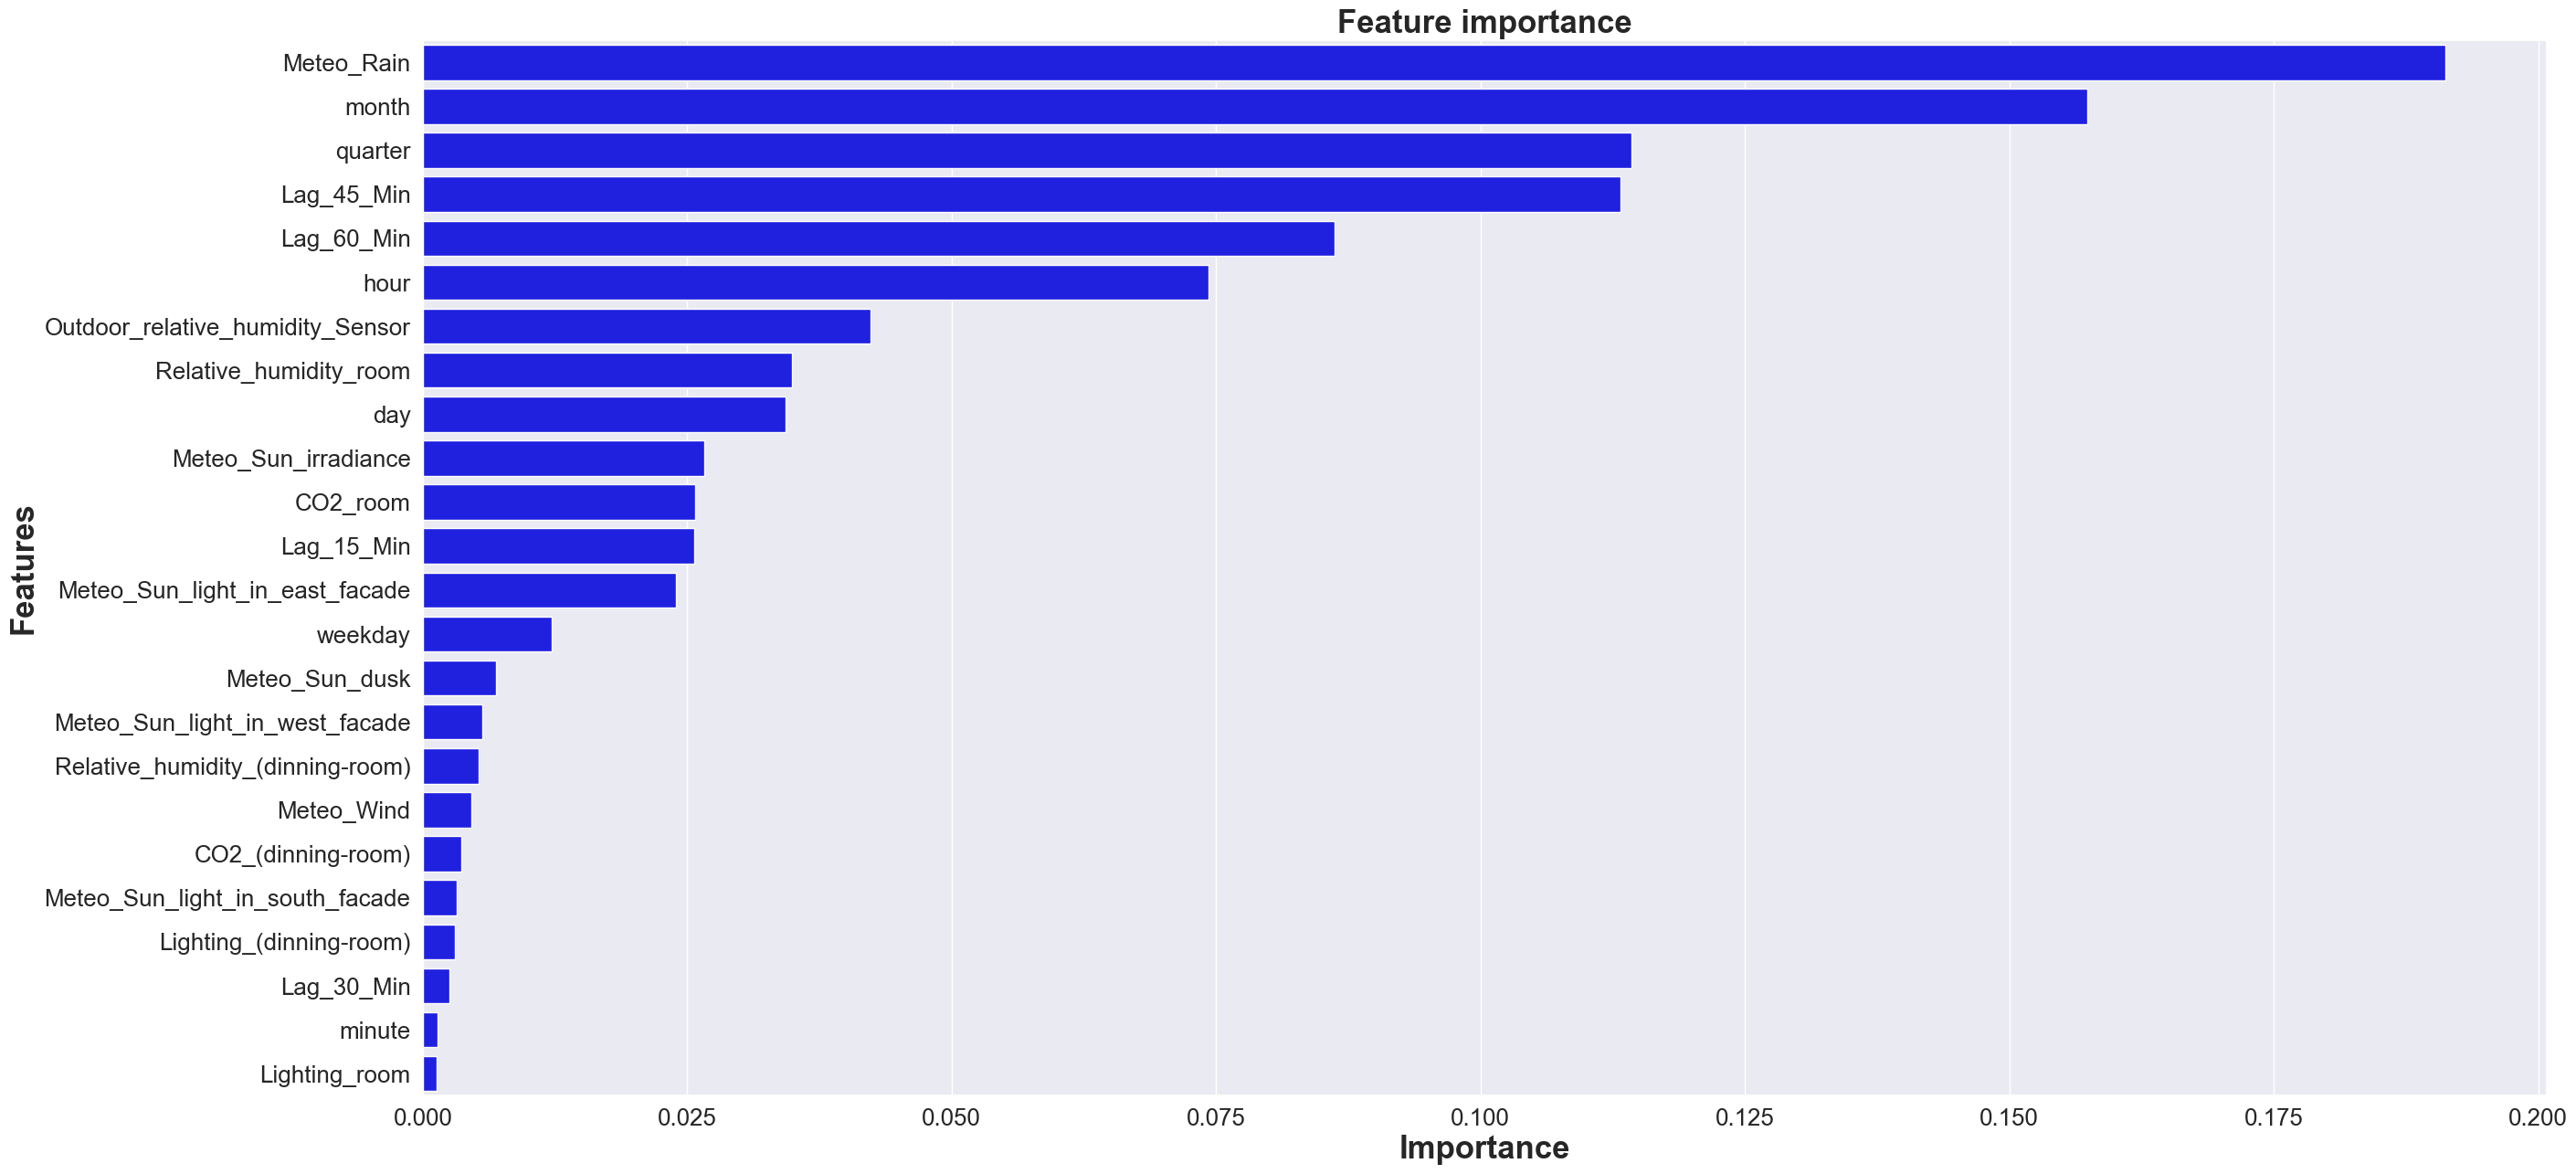

None

,Features,Gini-Importance
0,Meteo_Rain,0.191231
1,month,0.157411
2,quarter,0.114284
3,Lag_45_Min,0.113208
4,Lag_60_Min,0.086182
5,hour,0.074333
6,Outdoor_relative_humidity_Sensor,0.042328
7,Relative_humidity_room,0.034912
8,day,0.034350
9,Meteo_Sun_irradiance,0.026608


In [40]:
# Evaluation of the importance of the XGBoost model attributes
feature_importance(xgb, X_train)

The crucial parameters for the XGBoost model were day, lag 45 minutes, and hour. Now let's predict the temperature for the actual test data.

In [41]:
xgb = XGBRegressor(**random_search_xgb.best_params_)
xgb.fit(X_train, y_train)
prediction_actual = xgb.predict(X_test_actual)

We will place the obtained results into the 'sample_submission' and generate the output.

In [42]:
sample_submission['Indoor_temperature_room'] = np.where(sample_submission['Indoor_temperature_room'] == 0, \
                                                        prediction_actual, sample_submission['Indoor_temperature_room'])

In [43]:
sample_submission

,Id,Indoor_temperature_room
0,2764,19.036621
1,2765,19.050819
2,2766,19.122381
3,2767,19.122381
4,2768,19.194984
...,...,...
1368,4132,18.250147
1369,4133,17.231367
1370,4134,16.981880
1371,4135,17.131378


## Conclusion

To summarize, the best model for predicting bedroom temperature was the XGBoost model. The primary factors the model relied on for temperature prediction were the day, hour, and a 45-minute delay in humidity. The predicted results closely match the actual ones. Perhaps with more data, the results could be even better.

## List of sources

1. https://www.mrsolar.com/what-is-a-solar-panel/
2. https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e